In [1]:
import json
import pandas as pd
import requests
import datetime
import csv
from binance import Client
#import binance_keys
import matplotlib.pyplot as plt
binance_client = Client()

# Сбор Данных

In [2]:
# Binance Spot
def get_binance(symbol, interval, startTime, endTime, limit):
    url = "https://api.binance.com/api/v3/klines"

    startTime = str(int(startTime.timestamp() * 1000))
    endTime = str(int(endTime.timestamp() * 1000))


    req_params = {"symbol" : symbol, "interval" : interval, "startTime" : startTime, "endTime" : endTime, "limit" : limit}

    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text))
    if (len(df) == 0):
        return None
    
    df = df.iloc[:, 0:6]
    df.columns = ["datetime", "open", "high", "low", "close_spot_bin", "volume_spot_bin"]
    df["date"] = [datetime.datetime.fromtimestamp(x / 1000.0) for x in df["datetime"]]
    df['Date'] = pd.to_datetime(df['date']).dt.date
    df = df.set_index(df["Date"])
    df = df.drop(["datetime","open", "high", "low", "Date", "date"],axis = 1)
    return df

# Binance
df_binance_spot = get_binance(symbol = "ETHUSDT", interval = "1d",
                 startTime = datetime.datetime(2020,2,1),
                 endTime = datetime.datetime(2022,10,4), limit = "1000")
df_binance_spot.head()

,close_spot_bin,volume_spot_bin
Date,,
2020-02-01,183.60000000,259370.12902000
2020-02-02,188.44000000,552621.13619000
2020-02-03,189.69000000,417175.95781000
2020-02-04,188.91000000,366389.69686000
2020-02-05,203.78000000,550942.11417000


In [3]:
# FTX Spot
def get_ftx(market_name, frequency, start_time):
    api_url = 'https://ftx.us/api'
    #market_name = 'ETH/USD'
    resolution = 60 * 60 * 24 * frequency  #(seconds * minutes * days)
   # start_time = datetime.datetime(2022,1,1).timestamp()

    path = f'/markets/{market_name}/candles?resolution={resolution}&start={start_time}'
    url = api_url + path
    
    res = requests.get(url).json()
    df = pd.DataFrame(res['result'])
    df['date'] = pd.to_datetime(df['startTime'])
    df['Date'] = pd.to_datetime(df['date']).dt.date
    df = df.set_index(df["Date"])
    df = df.drop(["startTime","open", "high", "time", "low", "date", "Date"], axis = 1)
    df.columns = ["close_spot_ftx", "volume_spot_ftx"]
    return df

ftx_spot = get_ftx('ETH/USDT', 1, datetime.datetime(2022,9,1).timestamp())
ftx_spot.head()

,close_spot_ftx,volume_spot_ftx
Date,,
2020-06-17,233.875,0.0
2020-06-18,231.235,0.0
2020-06-19,229.055,0.0
2020-06-20,228.855,0.0
2020-06-21,228.115,0.0


In [4]:
# Uniswap Spot and Volume
url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'
query = """{
    pools(
        orderBy: volumeUSD,
        orderDirection: desc,
        first: 1,
      where: {
       token0: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2",
       token1: "0xdac17f958d2ee523a2206206994597c13d831ec7"},
        ) {
            id
            token0 {
                symbol
            }
            token1 {
                symbol
            }
            poolDayData(
                orderBy: date
                orderDirection: desc
                ){
                    date
                    token0Price
                    token1Price
                    high
                    low
                    open
                    close
      							volumeUSD
                }
            }
        }"""
response = requests.post(url, json={'query': query})
json_data = json.loads(response.text)
a = json_data.get("data").get("pools")[0].get("poolDayData")
df = pd.DataFrame(a)
    
   
#df["date"] = [datetime.datetime.fromtimestamp(x) for x in df["date"]]
df["date"] = [datetime.datetime.fromtimestamp(x) - datetime.timedelta(days=1) for x in df["date"]]
df['Date'] = pd.to_datetime(df['date']).dt.date

df = df.set_index(df["Date"])
df = df.drop(["date","token1Price","high","low","open", "Date","token0Price"], axis = 1)
df.columns = ["Close_DEX", "VolumeDEX"]
df["VolumeDEX"] = [float(x) for x in df["VolumeDEX"]]
df["Close_DEX"] = [1/float(x) for x in df["Close_DEX"]]
uni_spot = df
uni_spot.head()

,Close_DEX,VolumeDEX
Date,,
2022-10-09,1322.216108,1.689992e+07
2022-10-08,1315.726177,3.675705e+07
2022-10-07,1331.517338,2.930215e+07
2022-10-06,1351.553389,2.890063e+07
2022-10-05,1352.558380,3.579228e+07


In [5]:
# Binance Q Futures
def get_binance_futures(symbol, interval, start_str, end_str):
    df = binance_client.futures_historical_klines(symbol=symbol, interval=interval, start_str=start_str, end_str=end_str)
    df = pd.DataFrame(df)
    df = df.iloc[:,0:6]
    df.columns = ["datetime", "open", "high", "low", "close", "volume"]
    df["date"] = [datetime.datetime.fromtimestamp(x / 1000.0) for x in df["datetime"]]
    
    df['Date'] = pd.to_datetime(df['date']).dt.date
    df = df.set_index(df["Date"])
    df = df.drop(["datetime","open", "high",  "low", "date", "Date"], axis = 1)
    #df = df.drop(["startTime","open", "high", "time" "low", "Date", "date"], axis = 1)
    df.columns = ["close_Qfut_bin", "volume_Qfut_bin"]
    #df = df.set_index(df["date"])
    #df = df.drop(columns = ['datetime', 'date'])
    return df

binance_Q_futures = get_binance_futures(symbol='ETHUSDT', interval='1d',
                    start_str='2022-09-01', end_str='2022-10-05')
binance_Q_futures.head()

,close_Qfut_bin,volume_Qfut_bin
Date,,
2022-09-01,1585.40,9119984.942
2022-09-02,1574.49,9144439.365
2022-09-03,1556.41,3937946.105
2022-09-04,1578.14,3969402.047
2022-09-05,1616.92,5810610.257


In [6]:
# FTX Q Futures
api_url = 'https://ftx.us/api'
api = '/markets'
futures = '/ETH-1230'
resolutions = 'candles?resolution=86400&'
start_time= str(datetime.datetime.timestamp(datetime.datetime(2021,1,1)))
url = api_url + api + resolutions + start_time

df = requests.get('https://ftx.com/api/markets/ETH-1230/candles?resolution=86400&start_time=1609462800').json()
df = pd.DataFrame(df['result'])
df['Date'] = pd.to_datetime(df['startTime']).dt.date
df = df.set_index(df["Date"])
df = df.drop(["startTime", "time", "open", "high",  "low", "Date"], axis = 1)
    #df = df.drop(["startTime","open", "high", "time" "low", "Date", "date"], axis = 1)
df.columns = ["close_Qfut_ftx", "volume_fut_ftx"]
    #df = df.set_index(df["date"])
    #df = df.drop(columns = ['datetime', 'date'])
ftx_Q_futures = df
ftx_Q_futures.head()

,close_Qfut_ftx,volume_fut_ftx
Date,,
2022-06-10,1688.8,4.593337e+05
2022-06-11,1555.0,9.053540e+05
2022-06-12,1454.0,1.857308e+06
2022-06-13,1223.6,3.134731e+06
2022-06-14,1220.0,1.461191e+06


In [7]:
# Get Funding ftx
ftx_endpoint = 'https://ftx.com/api/'
start_time = (pd.to_datetime('2022-03-13')- pd.Timestamp("1970-01-01"))// pd.Timedelta('1s')
end_time = (pd.to_datetime('2022-09-13')- pd.Timestamp("1970-01-01"))// pd.Timedelta('1s')
futures = requests.get(ftx_endpoint+'futures').json()['result']
#funding_hist = requests.get(ftx_endpoint+'funding_rates',{'future':futures[0]['name'],'start_time': start_time, 'end_time': end_time}).json()['result']
#funding_hist = requests.get(ftx_endpoint+'funding_rates',{'future':"BTC-PERP",'start_time': start_time, 'end_time': end_time}).json()['result']
# Get BTC-perp data
funding_hist = requests.get(ftx_endpoint+'funding_rates',
                            {'future':"ETH-PERP",'start_time': start_time,
                             'end_time': end_time}).json()['result']
ftx_funding = pd.DataFrame(funding_hist)


ftx_funding = ftx_funding.set_index(ftx_funding["time"])
ftx_funding = ftx_funding.drop(['time', 'future'], axis=1)
ftx_funding

,rate
time,
2022-09-13T00:00:00+00:00,-0.000060
2022-09-12T23:00:00+00:00,-0.000059
2022-09-12T22:00:00+00:00,-0.000056
2022-09-12T21:00:00+00:00,-0.000057
2022-09-12T20:00:00+00:00,-0.000062
...,...
2022-08-23T09:00:00+00:00,-0.000010
2022-08-23T08:00:00+00:00,-0.000014
2022-08-23T07:00:00+00:00,-0.000023


In [8]:
#binance Funding
binance_endpoint = 'https://fapi.binance.com'
binance_BTCUSDT_hist = requests.get(binance_endpoint+'/fapi/v1/fundingRate',
                                    {'symbol':'ETHUSDT','startTime': start_time*1000,
                                     'endTime': end_time*1000,'limit':1000}).json()
binance_funding = pd.DataFrame(binance_BTCUSDT_hist)

binance_funding["fundingTime"] = [datetime.datetime.fromtimestamp(x / 1000) 
                                  for x in binance_funding["fundingTime"]    ]
binance_funding = binance_funding.drop(["symbol"], axis = 1)
binance_funding = binance_funding.set_index("fundingTime")
binance_funding.head()

,fundingRate
fundingTime,
2022-03-13 03:00:00.008,0.00002116
2022-03-13 11:00:00.000,0.00010000
2022-03-13 19:00:00.002,-0.00002698
2022-03-14 03:00:00.014,-0.00010352
2022-03-14 11:00:00.005,0.00010000


In [39]:
svod = df_binance_spot.merge(ftx_spot, on = ["Date"], how = 'left')
svod = svod.merge(binance_Q_futures, on = ["Date"], how = 'left')
svod = svod.merge(ftx_Q_futures, on = ["Date"], how = 'left')
svod = svod.merge(uni_spot, on = ["Date"], how = 'left')
svod = svod.dropna()

In [10]:
svod.head()

,close_spot_bin,volume_spot_bin,close_spot_ftx,volume_spot_ftx,close_Qfut_bin,volume_Qfut_bin,close_Qfut_ftx,volume_fut_ftx,Close_DEX,VolumeDEX
Date,,,,,,,,,,
2022-09-01,1586.16000000,728710.48200000,1586.4,3.527003e+06,1585.40,9119984.942,1554.2,1.963011e+07,1585.733834,6.642862e+07
2022-09-02,1575.35000000,919009.65980000,1575.3,4.194169e+06,1574.49,9144439.365,1544.3,2.132247e+07,1575.672780,2.517209e+07
2022-09-03,1557.46000000,321397.21890000,1557.2,2.225313e+06,1556.41,3937946.105,1527.7,1.623805e+07,1556.683342,2.195220e+07
2022-09-04,1579.28000000,296591.11660000,1579.1,1.355964e+06,1578.14,3969402.047,1548.2,1.484903e+07,1579.574818,6.484909e+07
2022-09-05,1617.80000000,503492.93700000,1617.3,1.301234e+06,1616.92,5810610.257,1588.3,2.104570e+07,1618.613227,8.962627e+07


In [11]:
ftx_funding.head()

,rate
time,
2022-09-13T00:00:00+00:00,-0.000060
2022-09-12T23:00:00+00:00,-0.000059
2022-09-12T22:00:00+00:00,-0.000056
2022-09-12T21:00:00+00:00,-0.000057
2022-09-12T20:00:00+00:00,-0.000062


In [12]:
_binance_funding = binance_funding
_binance_funding["fundingTime"] = _binance_funding.index
_binance_funding["fundingTime"] = [x.replace(microsecond=0) for x in _binance_funding["fundingTime"]]
_binance_funding = _binance_funding.set_index(_binance_funding["fundingTime"])
_binance_funding = _binance_funding.drop(["fundingTime"], axis = 1)

_ftx_funding = ftx_funding
_ftx_funding["fundingTime"] = _ftx_funding.index
#_ftx_funding["fundingTime"] = [datetime.datetime(x) for x in _ftx_funding["fundingTime"]]
_ftx_funding = _ftx_funding.set_index(_ftx_funding["fundingTime"])
_ftx_funding = _ftx_funding.drop(["fundingTime"], axis = 1)



In [13]:
_ftx_funding = ftx_funding
_ftx_funding["fundingTime"] = _ftx_funding.index
a =[]
for _lupa in _ftx_funding["fundingTime"]:
    
    _lupa = _lupa.split("+")[0]
    _lupa_date = _lupa.split("T")[0]
    _lupa_time = _lupa.split("T")[1]
    _lupa = _lupa_date + " "+ _lupa_time
    _lupa = datetime.datetime.strptime(_lupa, '%Y-%m-%d %H:%M:%S')
    a.append(_lupa)


    
_ftx_funding["fundingTime"] = a

_ftx_funding = _ftx_funding.set_index(_ftx_funding["fundingTime"])
_ftx_funding = _ftx_funding.drop(["fundingTime"], axis = 1)

In [14]:
svod_rates = _ftx_funding.merge(_binance_funding, on = ["fundingTime"], how = 'left')
svod_rates.fillna(method='bfill', inplace = True)
svod_rates.columns =["ftx_funding", "bin_funding"]
svod_rates["bin_funding"] = [float(x) for x in svod_rates["bin_funding"]]


# Анализ данных

## Сравнение цен на CEX и DEX

Text(0.5, 1.0, 'Spread between CEX and DEX spot close prices')

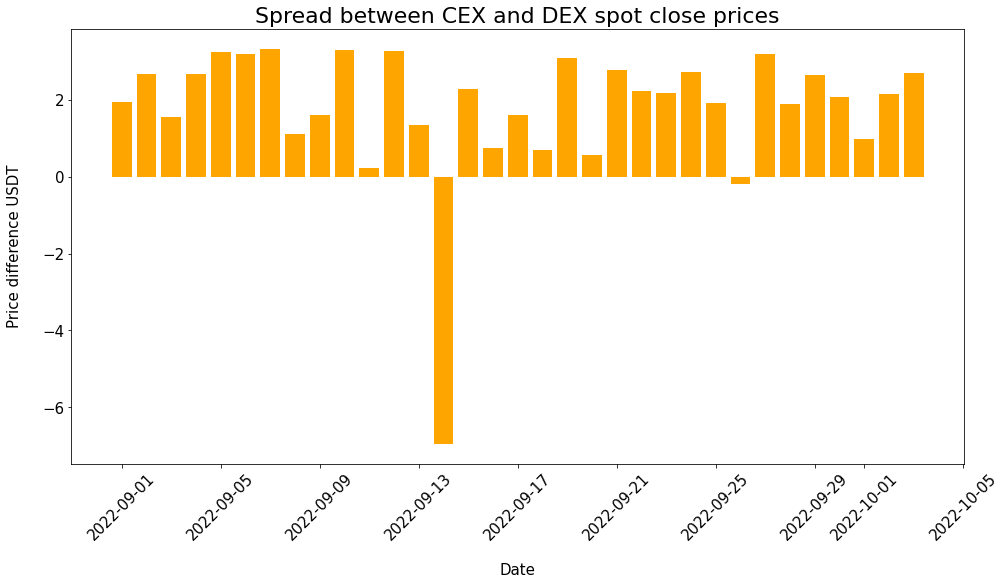

In [29]:
# Сравнение цен
svod["close_spot_bin"] = [float(x) for x in svod["close_spot_bin"]]
svod["Close_DEX"] = svod["Close_DEX"] * 1.0003 # add Comission 
svod["DEX_CEX_Spread"] = svod["Close_DEX"] - svod["close_spot_bin"]


plt.figure(figsize=(16,8))
plt.bar(x=svod.index, height = svod["DEX_CEX_Spread"], color = "orange")
plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Price difference USDT", fontsize =15, labelpad =20)
plt.title("Spread between CEX and DEX spot close prices", fontsize =22)

* Цены на DEX выше цен на CEX  Скорее всего в силу проскальзывания и комиссий
* Арбитражная возможность присутствует

## Сравнение цен на Binance и FTX

Text(0.5, 1.0, 'Arbitrage spread between Binance FTX Spot')

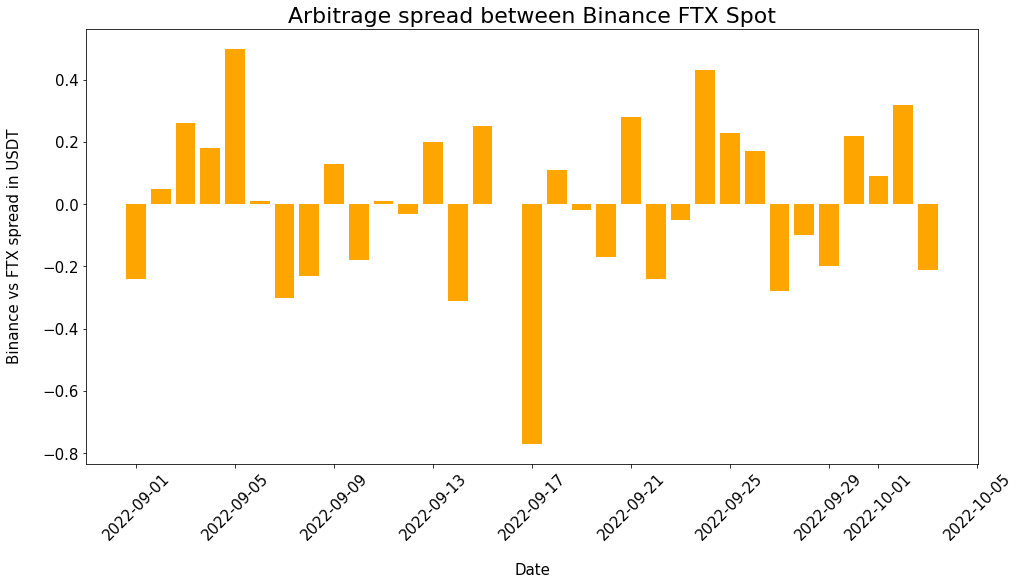

In [31]:
svod["close_spot_bin"] = [float(x) for x in svod["close_spot_bin"]]
svod["binance_ftx_spo_close_spread"] = svod["close_spot_bin"] - svod["close_spot_ftx"]

plt.figure(figsize=(16,8))
plt.bar(x=svod.index, height = svod["binance_ftx_spo_close_spread"], color = "orange")
plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Binance vs FTX spread in USDT", fontsize=15, labelpad =20)
plt.title("Arbitrage spread between Binance FTX Spot", fontsize =22)

* Размер спреда между двумся CEX гораздо меньше и разнонаправленный

Text(0.5, 1.0, 'Volumes Binance FTX Spot')

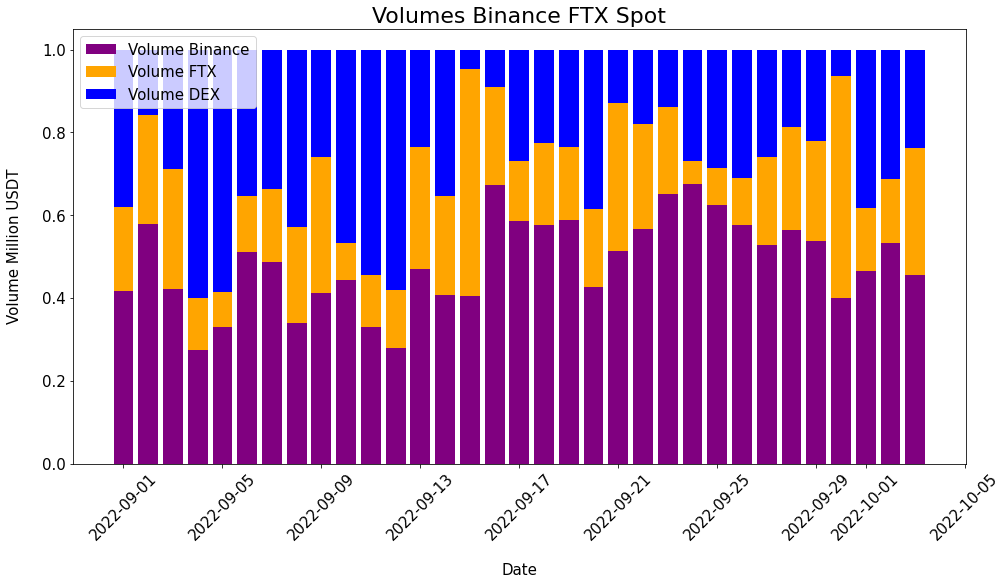

In [40]:
# Сравнение объемов
svod["volume_spot_bin"] = [float(x) for x in svod["volume_spot_bin"]]

svod["volume_spot_bin"] = svod["volume_spot_bin"] * 10
svod["VolumeDEX"] = svod["VolumeDEX"] / 10
svod["volume_spot_ftx"] = svod["volume_spot_ftx"] 
svod["total_volume"] = svod["volume_spot_ftx"] + svod["VolumeDEX"] + svod["volume_spot_bin"]

svod["Binance_volume_Percentage"] = [x/y for x,y in zip(svod["volume_spot_bin"],svod["total_volume"])]
svod["FTX_volume_Percentage"] = [x/y for x,y in zip(svod["volume_spot_ftx"],svod["total_volume"])]
svod["DEX_volume_Percentage"] = [x/y for x,y in zip(svod["VolumeDEX"],svod["total_volume"])]

plt.figure(figsize=(16,8))
plt.bar(x=svod.index, height=svod["Binance_volume_Percentage"], label = "Volume Binance", color="orange")
plt.bar(x=svod.index, height=svod["FTX_volume_Percentage"], label = "Volume FTX",
        bottom = svod["Binance_volume_Percentage"], color = "purple")
plt.bar(x=svod.index, height=svod["DEX_volume_Percentage"], label = "Volume DEX",
        color = "blue", bottom = svod["Binance_volume_Percentage"] + svod["FTX_volume_Percentage"])


plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)

plt.legend(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Volume Percentag", fontsize =15, labelpad =20)
plt.title("Volumes Binance FTX Spot", fontsize =22)

* Объем торгов на CEX опрежает DEX 
* Самая большая доля торгов у бинанс
* Скорее всего все миспрайсинги цены арбитражеры исправляют в паре с бинанс

## Сравнение Цен фьючерсов и спотов

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Binance Futures Spot Spread')

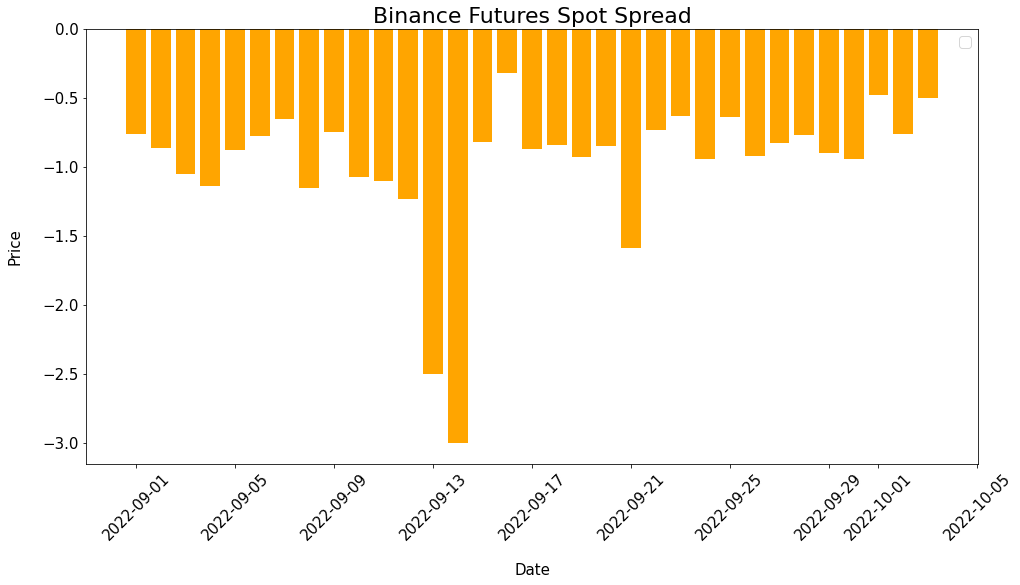

In [42]:
# Сравнение цен Perp фьюча и спота
svod["close_Qfut_bin"] = [float(x) for x in svod["close_Qfut_bin"]]
svod["close_spot_bin"] = [float(x) for x in svod["close_spot_bin"]]
svod["Binance_QFut_Spot_spread"] = svod["close_Qfut_bin"]  - svod["close_spot_bin"]

plt.figure(figsize=(16,8))
plt.bar(x=svod.index, height = svod["Binance_QFut_Spot_spread"], color = "orange")


plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Price", fontsize =15, labelpad =20)
plt.title("Binance Futures Spot Spread", fontsize =22)

* Цены на фьючерсном рынке на момент закрытия отстаяют от спотового рынка
* Размер спреда снижается за месяц, скорее всего связано с изменением срочности фьючерса

Text(0.5, 1.0, 'FTX Futures Spot Spread')

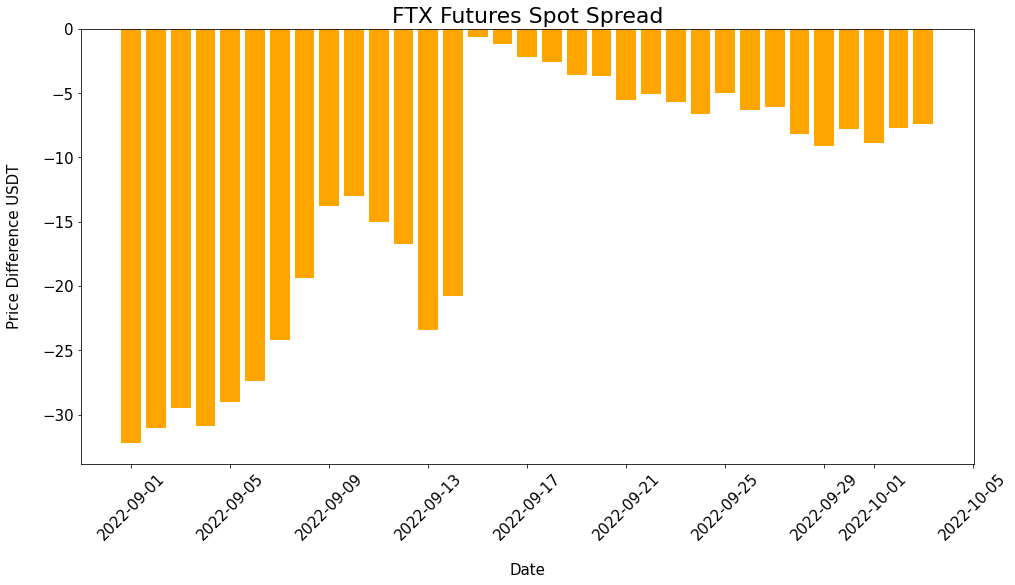

In [46]:
# Сравнение цен квартального фьюча и спота
svod["FTX_QFut_Spot_spread"] = svod["close_Qfut_ftx"] - svod["close_spot_ftx"] 

plt.figure(figsize=(16,8))
plt.bar(x=svod.index, height = svod["FTX_QFut_Spot_spread"], color = "orange")


plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Price Difference USDT", fontsize =15, labelpad =20)
plt.title("FTX Futures Spot Spread", fontsize =22)

* Цены на квартальные фьючерсы отстают от спота также как и на бинанс
* Размера спреда также снижается ближе к дате экспирации
* Размер спреда на FTX выше

Text(0.5, 1.0, 'Spread Between FTX and Binance Futures')

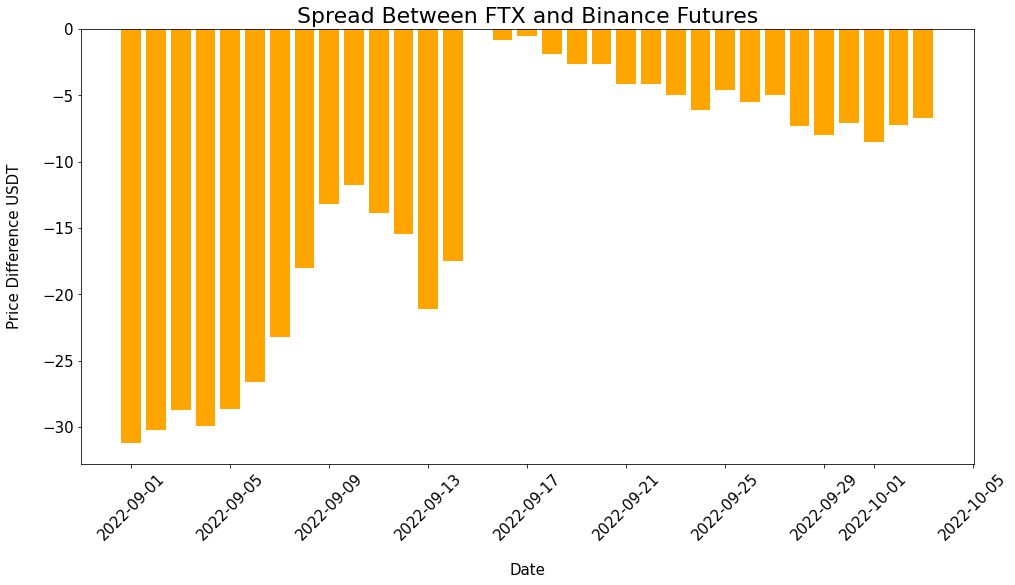

In [50]:
# Сравнение цен квартального фьюча бинанса и ftx
svod["FTX_Bin_QFut_spread"] = svod["close_Qfut_ftx"] - svod["close_Qfut_bin"] 

plt.figure(figsize=(16,8))
plt.bar(x=svod.index, height = svod["FTX_Bin_QFut_spread"], color = "orange")


plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Price Difference USDT", fontsize =15, labelpad =20)
plt.title("Spread Between FTX and Binance Futures", fontsize =22)

* Есть арбитражные возможности между биржами. Скорее всего ошибка в данных, выясню

### Funding Rates

No handles with labels found to put in legend.


Text(0.5, 1.0, 'FTX Funding Rate Distribution')

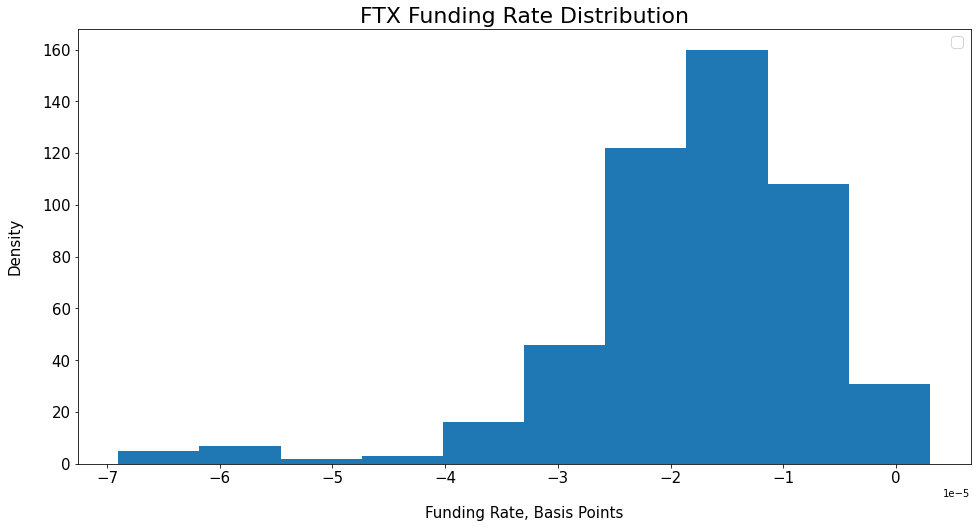

In [21]:
plt.figure(figsize=(16,8))
plt.hist(svod_rates["ftx_funding"])
plt.legend(fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Funding Rate, Basis Points", fontsize =15, labelpad =20)
plt.ylabel("Density", fontsize =15, labelpad =20)
plt.title("FTX Funding Rate Distribution", fontsize = 22)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Binance Funding Rate Distribution')

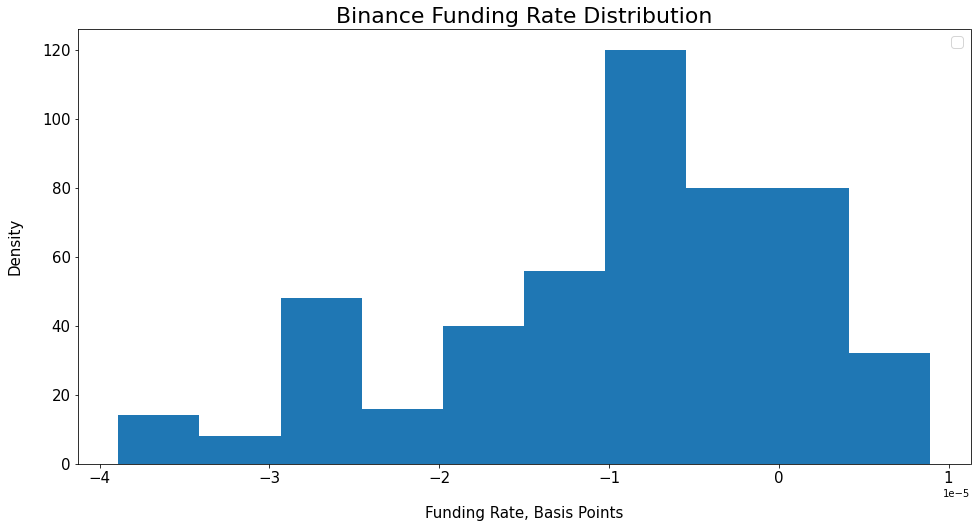

In [22]:
plt.figure(figsize=(16,8))
plt.hist(svod_rates["bin_funding"]/10)
plt.legend(fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Funding Rate, Basis Points", fontsize =15, labelpad =20)
plt.ylabel("Density", fontsize =15, labelpad =20)
plt.title("Binance Funding Rate Distribution", fontsize = 22)

In [24]:
svod_rates.agg({"bin_funding": [ "mean", "std", "min", "max", "median", "skew"],
               "ftx_funding": [ "mean", "std", "min", "max", "median", "skew"]})

,bin_funding,ftx_funding
mean,-0.000093,-0.000018
std,0.000106,0.000011
min,-0.000389,-0.000069
max,0.000089,0.000003
median,-0.000080,-0.000016
skew,-0.693939,-1.600466


* Фандинговы ставки за период сильно сдвинуты влево, что говорит о том, что цены спота превосходили фьючерсы за выбранный период
* с 95% вероятностью ставка по Binance не падала ниже чем 3,4  Для binance 1.78

Text(0.5, 1.0, 'Futures hourly Funding rates comparing')

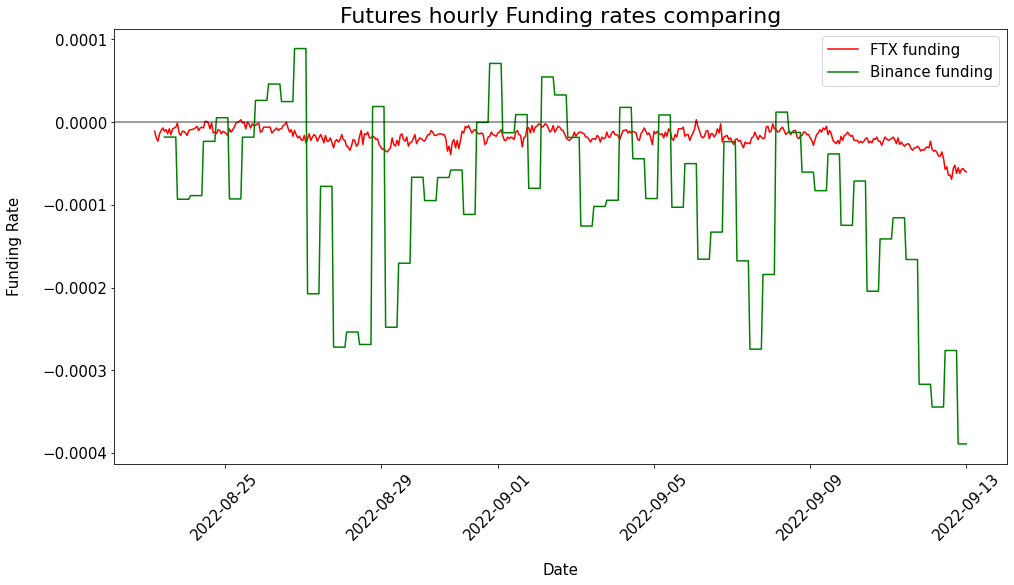

In [25]:
#Fundig rates
plt.figure(figsize=(16,8))
plt.plot(svod_rates["ftx_funding"], label = "FTX funding",  c ="red")
#plt.scatter(svod_rates.index, svod_rates["ftx_funding"])

plt.plot(svod_rates["bin_funding"], label = "Binance funding", c = "green")
plt.axhline(y=0, c = "black", alpha = 0.5)
#plt.scatter(svod_rates.index, svod_rates["Volume_bin"])
plt.legend(fontsize =15)
plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Funding Rate", fontsize =15, labelpad =20)
plt.title("Futures hourly Funding rates comparing", fontsize = 22)

* Ставки на Binance обновляются раз в 8 часов, а на ftx каждый час
* вариацаия ставок на binance существенно выше, чем на ftx
* ставки фондирования по ftx практически всегда отрицательные, возможно это можно использовать

# Что влияет на ставки 

* Цены на деривативы и спотовые активы
* Объемы торгов на спот рынке и рынке деривативов 
* Ставки по кредитам
* Фаза рынка
* Направление движения цены за период
* Объем пула ликвидности на DEX в этот момент

# Правки

**Правки**
* Перевести все числа в svod во float
* Переписать в одну функцию 
* Не хватает подписей и измерений на осях ++++
* Объемы лучше рисовать барчартами +++++ done
* Очень маленькие интервалы - брать стоит минимум годовой горизонт
* Делать разбивку по сезонностям рынка - переписать функцию в общую
* Стоит сделать детализацию для спредов: день, час, минуты - переписать функцию в общую
* Futures Funding rates Spread не очень информативно
* Не хватает аннуализированных фандингов и количесвтенных статистик по фандингам

**Графики**
1. Цена спота, перпета и квартальных
2. Фандинг акт, фанд анн
3. Спред перепета и спота
4. Цена пула из Графа и спред
5. Сравнить споты бинанса, фткс и граф (учитывать комиссии?) Замерить расхождение в процентах. 
Threshold - предел выгодности
6. Распределение посмотретьb
7. Глубина ликвидности*** - сколько 
8. Глубина стакана по перпетам и календар и споту и оценка насколько емкой может быть стратегия